# EE613 - Nonlinear Regression II - Exercise 2: GMR vs GPR

In [1]:
import sys
sys.path.append('../lib')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from mixture_model import *
from plot_utils import *
from scipy.stats import norm as normal_dist

%load_ext autoreload
%autoreload 2
%matplotlib inline

***

### Question 1: Computing GPR

#### Generate Data 

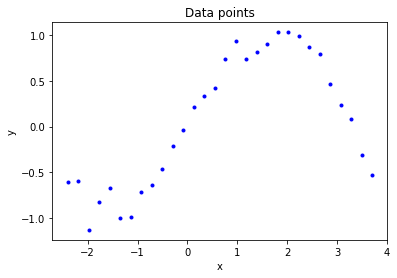

In [2]:
nb_data = 30
x = np.linspace(-2.4,3.7,nb_data)
Y = np.sin(1*x)[:,None] + np.random.normal(size=(nb_data, 1))*2e-1 

plt.plot(x,Y, '.b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data points')
plt.show()

#define the test input
x_test = np.linspace(-2.4,3.7)

Given the data {X,Y}, approximate the function $f(x) = y$ by GPR. Then, use the GPR to compute the prediction, given x_test, and plot the prediction (both the mean and the covariance).

Note: this is the same data that we use in Ex2 of Nonlinear Regression I with LWR and GMR 

### Q1 Solution 

#### Define functions for GPR 

In [3]:
def RBF_cov_function(x1,x2,params):
    return params[0] * np.exp(-(norm(x1-x2)**2)/params[1])

def compute_cov_matrix(X1,X2,params, cov_func = RBF_cov_function):
    #You can define other covariance function to replace RBF_cov_function
    n_row = len(X1)
    n_col = len(X2)
    K = np.zeros((n_row, n_col))
    for i in range(n_row):
        for j in range(n_col):
            K[i,j] = cov_func(X1[i], X2[j], params)
            
    return K

#### Compute the GPR parameters (the covariance matrix) 

In [4]:
from numpy.linalg import norm as norm
params = np.array([1, 0.6, 4e-2]) #GPR parameters: output scale, input scale and the noise variance
K = compute_cov_matrix(x,x,params)
K_inv = np.linalg.pinv(K + params[2]*np.eye(K.shape[0]))

#### Given the input xs, compute the prediction 

In [5]:
xs = x_test.copy() #the input

#Mean computation 
Ks = compute_cov_matrix(xs,x,params)
ys = np.dot(Ks, np.dot(K_inv,Y)) # the mean
#Uncertainty evaluation 
Kss = compute_cov_matrix(xs,xs,params)
S = Kss - np.dot(Ks, np.dot(K_inv, Ks.T)) #the covariance

Text(0,0.5,'y')

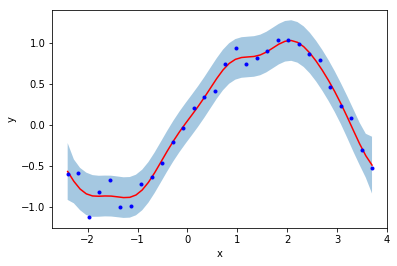

In [6]:
fig,ax = plt.subplots()
plot_with_covs_1D(xs, ys.flatten(), np.diag(S),ax)
plt.plot(x,Y, '.b')
plt.xlabel('x')
plt.ylabel('y')

### Question 2: Differences between GMR and GPR

#### Generate Incomplete Data with varying noise

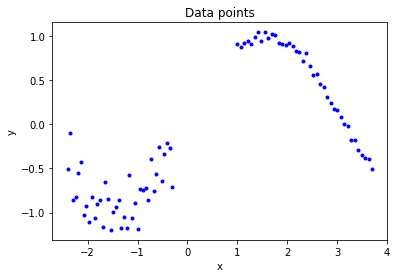

In [36]:
nb_data = 80

#x0 = np.linspace(-4.5,-2.4,nb_data)
#y0 = -1*np.ones(nb_data)[:,None] + np.random.normal(size=(nb_data, 1))*6e-2 
x1 = np.linspace(-2.4,-.3, nb_data/2)
y1 = np.sin(1*x1)[:,None] + np.random.normal(size=(nb_data/2, 1))*2e-1 
x2 = np.linspace(1,3.7, nb_data/2)
y2 = np.sin(1*x2)[:,None] + np.random.normal(size=(nb_data/2, 1))*3e-2 


x = np.hstack([x1,x2])
Y = np.vstack([y1,y2])

plt.plot(x,Y, '.b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data points')
plt.show()

#define the test input
x_test = np.linspace(-5,7)

Given the data {X,Y}, use GMR and GPR to approximate the mapping $f(x) = y$, and compute the predictions on x_test.

What are the difference between GMR and GPR:
i) In the region when there is no training data
ii) When the noises are heterogeneous (i.e. different noise amplitude in different input region)

### Q2 Solution 

### i) GPR

#### Compute the GPR parameters (the covariance matrix) 

In [40]:
from numpy.linalg import norm as norm
params = np.array([1,1, 4e-1]) #GPR parameters: output scale, input scale and the noise variance
K = compute_cov_matrix(x,x,params)
K_inv = np.linalg.pinv(K + params[2]*np.eye(K.shape[0]))

#### Given the input xs, compute the prediction 

In [41]:
xs = x_test.copy() #the input

#Mean computation 
Ks = compute_cov_matrix(xs,x,params)
ys = np.dot(Ks, np.dot(K_inv,Y)) # the mean
#Uncertainty evaluation 
Kss = compute_cov_matrix(xs,xs,params)
S = Kss - np.dot(Ks, np.dot(K_inv, Ks.T)) #the covariance

Text(0,0.5,'y')

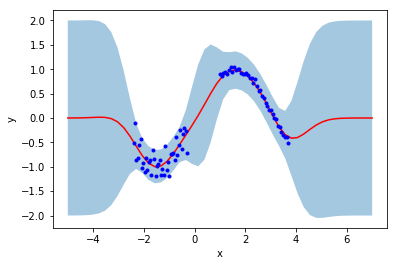

In [42]:
fig,ax = plt.subplots()
plot_with_covs_1D(xs, ys.flatten(), np.diag(S),ax)
plt.plot(x,Y, '.b')
plt.xlabel('x')
plt.ylabel('y')

### ii) GMR 

#### Defining the input data 

In [43]:
#input
X = x[:,None]
#joint data
data_joint = np.hstack([X, Y])  
D = data_joint.shape[1]

#### Estimate GMM using the data 

In [46]:
from IPython.display import clear_output

[1.0, 1.0, 1.0, 1.0]


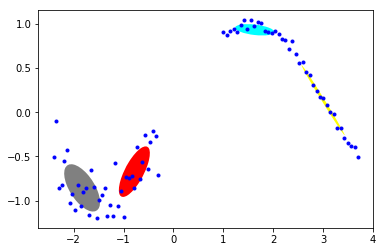

In [47]:
n_states = 4
gmm = GMM(D=D,K=n_states,M=1,N=1000)
gmm.fit(data_joint)
clear_output()
#plot only the spatial components
fig, ax = plt.subplots(figsize = (6,4))
colors = [[1.,0.,0.],[1.,1.,0.],[0.5,0.5,0.5],[0.,1.,1.],[0.,1.,0.],[0.,0.,1.],]
plot_GMM(gmm.means_, gmm.covariances_,ax,colors=colors)
plt.plot(x,Y, '.b')

#### Create a GMR class 

In [48]:
dim_in = slice(0,1)
dim_out = slice(1,2)
gmr = GMR(gmm,dim_in = dim_in, dim_out = dim_out)

#### Predict the data based on the time input

In [49]:
y_preds = []
covs = []
for x_i in x_test:
    y,cov = gmr.predict(x_i)
    y_preds.append(y)
    covs.append(cov)
    
y_preds = np.array(y_preds)
covs = np.array(covs)

#### Plot the prediction 

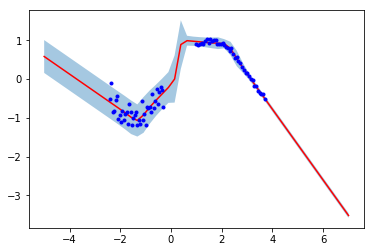

In [51]:
fig,ax = plt.subplots()
plot_with_covs_1D(x_test,y_preds.flatten(),covs.flatten(),ax)
plt.plot(x,Y, '.b')

***